# Customer Segment Classification

## Getting the data

#### Data Summary

In [369]:
import pandas as pd
pd.set_option("display.max_rows", 100)


train = pd.read_csv('raw_data/Train.csv')
train_exp = train.copy() # For data exploration
train.drop('ID',axis=1,inplace=True) #TODO: Handle excluded rows in target

#test = pd.read_csv('raw_data/Test.csv')
#y_test, X_test = test.loc[:, test.columns == 'Segmentation'].copy(), test.drop('Segmentation', axis=1)

train.head()


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [280]:
train.describe()

,Age,Work_Experience,Family_Size
count,8068.000000,7239.000000,7733.000000
mean,43.466906,2.641663,2.850123
std,16.711696,3.406763,1.531413
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


In [281]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   object 
 1   Ever_Married     7928 non-null   object 
 2   Age              8068 non-null   int64  
 3   Graduated        7990 non-null   object 
 4   Profession       7944 non-null   object 
 5   Work_Experience  7239 non-null   float64
 6   Spending_Score   8068 non-null   object 
 7   Family_Size      7733 non-null   float64
 8   Var_1            7992 non-null   object 
 9   Segmentation     8068 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 630.4+ KB


#### Null Handling

In [372]:
# Missing values per feature
train.isnull().sum(axis = 0)

Gender               0
Ever_Married         0
Age                  0
Graduated            0
Profession         114
Work_Experience      0
Spending_Score       0
Family_Size          0
Var_1                0
Segmentation         0
dtype: int64

In [283]:
train.isnull().sum(axis=1).value_counts()

0    6665
1    1244
2     140
3      18
4       1
dtype: int64

In [371]:
# Remove NA rows for features with low NA row counts (< 1% of total raw row count)
train.dropna(how='any', subset=['Graduated'], axis=0, inplace=True)
train.dropna(how='any', subset=['Var_1'], axis=0, inplace=True)

# Impute Boolean Features with Mode
train['Ever_Married'].fillna(train['Ever_Married'].mode()[0], inplace=True)


# Impute WE with median at ~1 as mean (2.64) is skewed towards 75th percentile (4)
train['Work_Experience'].fillna(train['Work_Experience'].median(), inplace=True)


# Impute Family size with mean (2.85) which aligns close to median (3)
train['Family_Size'].fillna(train['Family_Size'].mean(), inplace=True)


# NA values of Profession will report as all zeros post one hot encoding - no need to prefilter

In [332]:
train['Profession'].value_counts(dropna=False)

Artist           2477
Healthcare       1305
Entertainment     931
Engineer          690
Doctor            678
Lawyer            605
Executive         589
Marketing         285
Homemaker         240
NaN               114
Name: Profession, dtype: int64

In [355]:
train['Ever_Married'].value_counts(dropna=False)

Yes    4555
No     3224
NaN     135
Name: Ever_Married, dtype: int64

In [374]:
train.isnull().sum(axis = 0)


Gender               0
Ever_Married         0
Age                  0
Graduated            0
Profession         114
Work_Experience      0
Spending_Score       0
Family_Size          0
Var_1                0
Segmentation         0
dtype: int64

#### Preprocessing boolean  variables

In [373]:
train['Ever_Married'] = train['Ever_Married'].map({'No': False, 'Yes': True})
train['Graduated'] = train['Graduated'].map({'No': False, 'Yes': True})

train.head()
#train['Ever_Married'].value_counts()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,False,22,False,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,True,38,True,Engineer,1.0,Average,3.0,Cat_4,A
2,Female,True,67,True,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,True,67,True,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,True,40,True,Entertainment,1.0,High,6.0,Cat_6,A


#### One Hot encode categorical variables

In [375]:
from sklearn.preprocessing import OneHotEncoder


    
# Gender
gender_enc = OneHotEncoder()
gen_encoded = gender_enc.fit_transform(train[['Gender']]) # returns df of included col indcs
train[gender_enc.categories_[0]] = gen_encoded.toarray()

# Profession
prof_enc = OneHotEncoder(handle_unknown='ignore')
prof_encoded = prof_enc.fit_transform(train[['Profession']])
train[['prof_'+str(i) for i in prof_enc.categories_[0]]] = prof_encoded.toarray()

# Spending Score
ss_enc = OneHotEncoder()
ss_encoded = ss_enc.fit_transform(train[['Spending_Score']]) 
train[['ss_'+ i for i in ss_enc.categories_[0]]] = ss_encoded.toarray()

var1_enc = OneHotEncoder()
var1_encoded = var1_enc.fit_transform(train[['Var_1']]) 
train[var1_enc.categories_[0]] = var1_encoded.toarray()



train.drop(['prof_nan','Profession','Gender','Spending_Score','Var_1'],axis=1, inplace=True)
    
    
    



#### Scale the continous features

In [376]:
from sklearn.preprocessing import StandardScaler

#Age Scaler
age_scaler = StandardScaler()
age_scaled = age_scaler.fit_transform(train[['Age']])
train['Age'] = age_scaled



#Work Experience
work_scaler = StandardScaler()
work_scaled = work_scaler.fit_transform(train[['Work_Experience']])
train['Work_Experience'] = work_scaled


#Family Size
fam_scaler = StandardScaler()
fam_scaled = fam_scaler.fit_transform(train[['Family_Size']])
train['Family_Size'] = fam_scaled

train.head()




,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Segmentation,Female,Male,prof_Artist,prof_Doctor,...,ss_Average,ss_High,ss_Low,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7
0,False,-1.286003,False,-0.449653,0.768002,D,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,True,-0.326660,True,-0.449653,0.101002,A,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,True,1.412149,True,-0.449653,-1.232998,B,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,True,1.412149,True,-0.755659,-0.565998,B,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,True,-0.206742,True,-0.449653,2.102002,A,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Explore the data

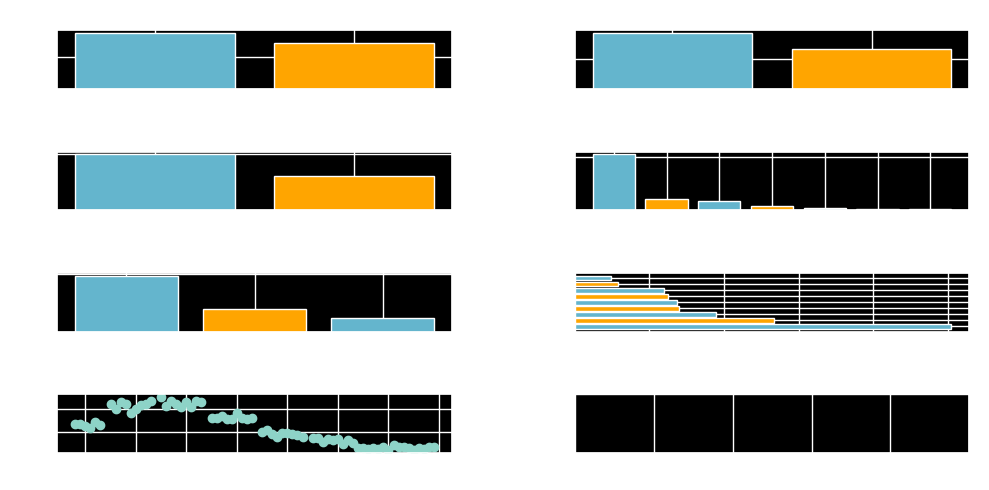

In [377]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
%matplotlib inline

fig, axs = plt.subplots(4,2,figsize=(10,8), dpi=100)
fig.set_figheight(5)
fig.set_figwidth(10)

gender_counts = train_exp['Gender'].value_counts()
em_counts = train_exp['Ever_Married'].value_counts()
grad_counts = train_exp['Graduated'].value_counts()
var1_counts = train_exp['Var_1'].value_counts()
ss_scounts = train_exp['Spending_Score'].value_counts()
prof_scounts = train_exp['Profession'].value_counts()
age_scounts = train_exp['Age'].value_counts()




axs[0,0].bar(gender_counts.index, gender_counts, color=['c','orange'])
axs[0,1].bar(em_counts.index, em_counts, color=['c','orange'])
axs[2,0].bar(ss_scounts.index, ss_scounts, color=['c','orange'])
axs[1,0].bar(grad_counts.index, grad_counts, color=['c','orange'])
axs[1,1].bar(var1_counts.index, var1_counts, color=['c','orange'])
axs[2,1].barh(prof_scounts.index, prof_scounts, color=['c','orange'])
axs[3,0].scatter(age_scounts.index, age_scounts)




axs[0,0].title.set_text('Gender')
axs[0,1].title.set_text('Ever_Married')
axs[2,0].title.set_text('Spending_Score')
axs[1,0].title.set_text('Graduated')
axs[1,1].title.set_text('Var_1')
axs[2,1].title.set_text('Profession')
axs[3,0].title.set_text('Age')


fig.tight_layout()



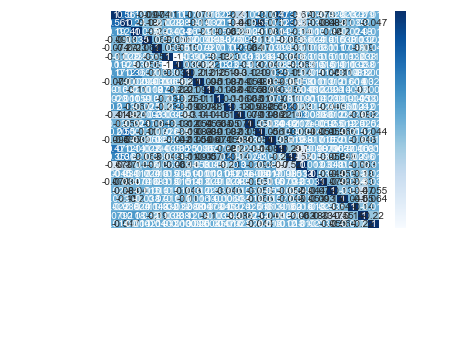

In [530]:
corr = train.corr()
sns.heatmap(corr,cmap="Blues",annot=True)
plt.rcParams['figure.figsize'] = [25, 15]


## Model the Data

### Logistic Regression (nd)

In [463]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
import numpy as np


y_train, X_train = train.loc[:, train.columns == 'Segmentation'].copy(), train.drop('Segmentation', axis=1)
le = LabelEncoder()
le.fit(y_train.values.ravel())
y_train_labels = le.transform(y_train.values.ravel())


In [484]:
log_clf = LogisticRegression(multi_class='ovr',random_state=0, solver='saga',max_iter=500)

distributions = dict(C=uniform(loc=0,scale=1),penalty=['l2','l1'], multi_class=['ovr','multinomial'])

rand_clf = RandomizedSearchCV(log_clf, distributions, random_state=0, verbose=1)
r_search = rand_clf.fit(X_train, y_train_labels)
r_search.best_params_



Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'C': 0.07103605819788694, 'multi_class': 'multinomial', 'penalty': 'l2'}

In [485]:
grid_values = {'penalty': ['l1', 'l2'],'C':[0.05,0.01,0.09,1,2,3,5], 'multi_class':['ovr','multinomial']}
grid_clf = GridSearchCV(log_clf, grid_values, verbose=1)
grid_search = grid_clf.fit(X_train, y_train_labels)
grid_search.best_params_

Fitting 5 folds for each of 28 candidates, totalling 140 fits


/Users/daltonsi/analysis/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/daltonsi/analysis/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/daltonsi/analysis/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/daltonsi/analysis/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/daltonsi/analysis/env/lib/python3.8/site-packages/sklearn/linear_mode

{'C': 0.09, 'multi_class': 'multinomial', 'penalty': 'l2'}

In [532]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


log_clf = LogisticRegression(multi_class='multinomial',random_state=0, solver='saga', max_iter=500, penalty='l2',C=0.075)
log_clf.fit(X_train, y_train_labels)
y_pred = log_clf.predict(X_train)
accuracy_score(y_pred, y_train_labels)

print('Train metrics...')
print(confusion_matrix(y_train_labels, y_pred))
print(classification_report(y_train_labels, y_pred))

Train metrics...
[[ 939  247  367  376]
 [ 569  396  647  215]
 [ 250  234 1193  257]
 [ 452   90   98 1584]]
              precision    recall  f1-score   support

           0       0.42      0.49      0.45      1929
           1       0.41      0.22      0.28      1827
           2       0.52      0.62      0.56      1934
           3       0.65      0.71      0.68      2224

    accuracy                           0.52      7914
   macro avg       0.50      0.51      0.50      7914
weighted avg       0.51      0.52      0.50      7914



In [487]:
scores = cross_val_score(log_clf, X_train, y_train_labels, cv=10)
print(f"10-fold cross validation average accuracy: {(scores.mean()*100).round(3)} %")


10-fold cross validation average accuracy: 51.225 %


### Decision Tree (n logn d)

In [491]:
from sklearn.tree import DecisionTreeClassifier


tree_clf = DecisionTreeClassifier(random_state=0)
tree_clf.fit(X_train, y_train_labels)
y_pred = tree_clf.predict(X_train)


In [490]:
scores = cross_val_score(tree_clf, X_train, y_train_labels, cv=10)
print(f"10-fold cross validation average accuracy: {(scores.mean()*100).round(3)} %")

10-fold cross validation average accuracy: 43.126 %


In [494]:
param_dict = {
    "criterion":['gini','entropy'],
    "max_depth":range(1,10),
    "min_samples_split":range(2,10),
    "min_samples_leaf":range(1,10)
}


rand_tree_clf = RandomizedSearchCV(tree_clf, param_dict, random_state=0, verbose=1)
r_tree_search = rand_tree_clf.fit(X_train, y_train_labels)
r_tree_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 4,
 'criterion': 'gini'}

In [497]:
grid_tree_clf = GridSearchCV(tree_clf, param_dict, verbose=1)
grid_search = grid_tree_clf.fit(X_train, y_train_labels)
grid_search.best_params_

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 6}

In [535]:
tree_clf = DecisionTreeClassifier(random_state=0, criterion='gini',max_depth=5,min_samples_leaf=1,min_samples_split=6)
tree_clf.fit(X_train, y_train_labels)
y_pred = tree_clf.predict(X_train)

scores = cross_val_score(tree_clf, X_train, y_train_labels, cv=10)
print(f"10-fold cross validation average accuracy: {(scores.mean()*100).round(3)} %")

print('Train metrics...')
print(confusion_matrix(y_train_labels, y_pred))
print(classification_report(y_train_labels, y_pred))


10-fold cross validation average accuracy: 52.135 %
Train metrics...
[[ 955  373  216  385]
 [ 488  576  556  207]
 [ 214  369 1090  261]
 [ 469  119   38 1598]]
              precision    recall  f1-score   support

           0       0.45      0.50      0.47      1929
           1       0.40      0.32      0.35      1827
           2       0.57      0.56      0.57      1934
           3       0.65      0.72      0.68      2224

    accuracy                           0.53      7914
   macro avg       0.52      0.52      0.52      7914
weighted avg       0.53      0.53      0.53      7914



### Random Forest (n logn d k)

In [500]:
from sklearn.ensemble import RandomForestClassifier


rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train_labels)
y_pred = rf_clf.predict(X_train)

accuracy_score(y_pred, y_train_labels)

0.9519838261309073

In [501]:
scores = cross_val_score(rf_clf, X_train, y_train_labels, cv=10)
print(f"10-fold cross validation average accuracy: {(scores.mean()*100).round(3)} %")

10-fold cross validation average accuracy: 48.445 %


In [504]:
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


rand_rf_clf = RandomizedSearchCV(rf_clf, param_dict, random_state=0, verbose=1)
r_rf_search = rand_rf_clf.fit(X_train, y_train_labels)
r_rf_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'min_samples_split': 9,
 'min_samples_leaf': 1,
 'max_depth': 8,
 'criterion': 'gini'}

In [503]:
grid_rf_clf = GridSearchCV(rf_clf, param_dict, verbose=1)
rf_search = grid_rf_clf.fit(X_train, y_train_labels)
rf_search.best_params_

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 3,
 'min_samples_split': 9}

In [536]:
rf_clf = RandomForestClassifier(random_state=0, criterion='gini',max_depth=9,min_samples_leaf=3,min_samples_split=9)
rf_clf.fit(X_train, y_train_labels)
y_pred = rf_clf.predict(X_train)

scores = cross_val_score(rf_clf, X_train, y_train_labels, cv=10)
print(f"10-fold cross validation average accuracy: {(scores.mean()*100).round(3)} %")

print('Train metrics...')
print(confusion_matrix(y_train_labels, y_pred))
print(classification_report(y_train_labels, y_pred))



10-fold cross validation average accuracy: 53.702 %
Train metrics...
[[1101  279  216  333]
 [ 398  744  469  216]
 [ 214  273 1179  268]
 [ 361  105   33 1725]]
              precision    recall  f1-score   support

           0       0.53      0.57      0.55      1929
           1       0.53      0.41      0.46      1827
           2       0.62      0.61      0.62      1934
           3       0.68      0.78      0.72      2224

    accuracy                           0.60      7914
   macro avg       0.59      0.59      0.59      7914
weighted avg       0.59      0.60      0.59      7914



#### ASIDE: FEATURE IMPORTANCES

In [539]:
forest_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
forest_importances

Age                   0.236803
prof_Healthcare       0.129715
ss_Low                0.104832
prof_Artist           0.099247
Graduated             0.073218
Ever_Married          0.056739
Family_Size           0.056225
ss_Average            0.044565
Work_Experience       0.038926
Cat_4                 0.017704
Cat_6                 0.016399
prof_Marketing        0.016292
prof_Entertainment    0.016239
Female                0.014529
ss_High               0.013321
Male                  0.013015
prof_Engineer         0.010942
prof_Executive        0.007043
Cat_3                 0.007040
prof_Doctor           0.006601
Cat_2                 0.005382
prof_Lawyer           0.004653
prof_Homemaker        0.004443
Cat_7                 0.002903
Cat_1                 0.001988
Cat_5                 0.001237
dtype: float64

### SVM (n^2)

In [540]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train_labels)
y_pred = svm_clf.predict(X_train)

accuracy_score(y_pred, y_train_labels)

0.5809957038160223

In [541]:
scores = cross_val_score(rf_clf, X_train, y_train_labels, cv=10)
print(f"10-fold cross validation average accuracy: {(scores.mean()*100).round(3)} %")

10-fold cross validation average accuracy: 53.702 %


In [ ]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

rand_svc_clf = RandomizedSearchCV(svm_clf, param_grid, random_state=0, verbose=2)
r_svc_search = rand_svc_clf.fit(X_train, y_train_labels)
r_svc_search.best_params_



Fitting 5 folds for each of 10 candidates, totalling 50 fits


### Ensemble Classifier

In [537]:
from sklearn.ensemble import VotingClassifier

eclf1 = VotingClassifier(estimators=[('log', log_clf), ('tree', tree_clf), ('rf', rf_clf)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train_labels)
y_pred = eclf1.predict(X_train)


accuracy_score(y_pred, y_train_labels)

print('Train metrics...')
print(confusion_matrix(y_train_labels, y_pred))
print(classification_report(y_train_labels, y_pred))



Train metrics...
[[1073  286  222  348]
 [ 489  613  515  210]
 [ 238  292 1143  261]
 [ 428  105   34 1657]]
              precision    recall  f1-score   support

           0       0.48      0.56      0.52      1929
           1       0.47      0.34      0.39      1827
           2       0.60      0.59      0.59      1934
           3       0.67      0.75      0.71      2224

    accuracy                           0.57      7914
   macro avg       0.56      0.56      0.55      7914
weighted avg       0.56      0.57      0.56      7914



In [538]:
eclf2 = VotingClassifier(estimators=[('log', log_clf), ('tree', tree_clf), ('rf', rf_clf)], voting='soft')
eclf2 = eclf1.fit(X_train, y_train_labels)
y_pred = eclf2.predict(X_train)


accuracy_score(y_pred, y_train_labels)

print('Train metrics...')
print(confusion_matrix(y_train_labels, y_pred))
print(classification_report(y_train_labels, y_pred))



Train metrics...
[[1073  286  222  348]
 [ 489  613  515  210]
 [ 238  292 1143  261]
 [ 428  105   34 1657]]
              precision    recall  f1-score   support

           0       0.48      0.56      0.52      1929
           1       0.47      0.34      0.39      1827
           2       0.60      0.59      0.59      1934
           3       0.67      0.75      0.71      2224

    accuracy                           0.57      7914
   macro avg       0.56      0.56      0.55      7914
weighted avg       0.56      0.57      0.56      7914

